# Homework 3: Visualizing Data with Movies

Name: Edward Chen

Date: 2/7/2025

#### Overview
In this homework, you'll create a movie visualization of a model parameter such as temperature, salinity, velocity, or any other field which may be of interest to you.

As an example, I've provided a movie of circulation in the Equatorial Pacific from the NASA ECCO Version 5 State Estimate. For the purposes of this visualization, I subsetted the Equatorial Pacific is the region between 155-75$^{\circ}$W and $\pm$20$^{\circ}$N.

#### Import Modules
Import the modules required to access data from netCDF files, plot it, and stitch panels together into a movie:

In [7]:
# import modules here
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import moviepy.video.io.ImageSequenceClip

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cm

## Part 1: Download Data
To begin this exercise, download all of the available data for your variable of interest over the timespan of interest.

For the example provided, I've used daily sea surface temperature data for a given year (2015) from the ECCO Version 5 Alpha output [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/latlon_daily/SST.nc).

To obtain your data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes. Be sure to edit the fields to obtain the correct data.

In [8]:
# define the path to the data folder
data_folder = '/Users/eddie/Documents/CS185C/Data'

## Part 2: Create a Single Plot of Sea Surface Temperature
Before making a movie, its useful to fine tune a single plot to get the details right. Once you've got your plot lookin' good, you can loop through all of the data to generate the panels of your movie.

Here, make a plot of one variable field. 

Begin by reading in the longitude, latitude, and SST fields from the netCDF file:

In [9]:
# read in the data

# make a path to a temperature file
temp_file = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','THETA','THETA_2015_01.nc')

# read in the temperature data at along with the
# latitude and longitude information 
ds = xr.open_dataset(temp_file)
longitude = np.array(ds['longitude'][:])
latitude = np.array(ds['latitude'][:])
Theta = np.array(ds['THETA'][:])
ds.close()


Next, find the locations of the longitude and latitude bounds within the global grid for your region of interest:

In [51]:
# define the longitude/latitude bounds
min_lon = -180
max_lon = -100
min_lat = 20
max_lat = 60

# compute the min/max row/col in the data grid
min_row = np.argmin(np.abs(latitude - min_lat))
max_row = np.argmin(np.abs(latitude - max_lat))
min_col = np.argmin(np.abs(longitude - min_lon))
max_col = np.argmin(np.abs(longitude - max_lon))

print(f"Min Row: {min_row}, Max Row: {max_row}")
print(f"Min Col: {min_col}, Max Col: {max_col}")

Min Row: 219, Max Row: 299
Min Col: 0, Max Col: 159


Use the row and column bounds to subset the longitude, latitude, and your variable:

In [54]:
# subset the data

Theta_subset = Theta[0, min_row:max_row + 1, min_col:max_col + 1]
lon_subset = longitude[min_col:max_col + 1]  
lat_subset = latitude[min_row:max_row + 1]   


Finally, make a plot with your subsetted data. For the plot specification, you can use any colormap, data range, and format as you like.

For my example, I find that the temperature plot looks nice with a figure size of (8,4), a turbo colormap, and a data range of 20-31. However, you are encouraged to format your plot to your tastes.

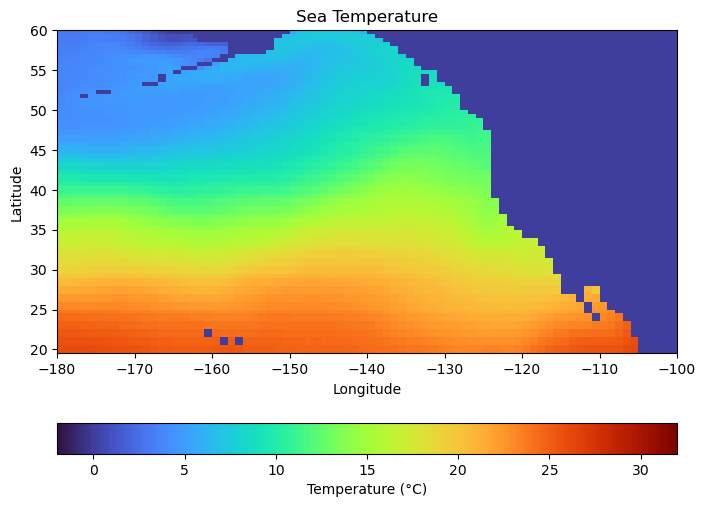

In [57]:
# Create the figure
fig = plt.figure(figsize=(8, 6))

# Plot the temperature data 
plt.pcolormesh(Lon, Lat, Theta_subset, vmin=-2, vmax=32, cmap='turbo')
plt.colorbar(orientation='horizontal', label='Temperature (°C)')

# Format the axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Temperature')

# Show the plot
plt.show()


## Part 3: Formulate a Plotting Function
When you are happy with your plot, make your code into a function that will take the year, month, and day as inputs, and output the figure into a given directory. 

In [75]:
def plot_panel(year, month, day):
    file_path = 'frames/THETA_01.png'
    frames_directory = 'frames'

    # Create a figure object with a map projection
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.Orthographic(central_latitude=50))

    # Plot the temperature data
    plt.pcolormesh(lon_subset, lat_subset, Theta_subset, vmin=-2, vmax=32, cmap='turbo')
    plt.colorbar(orientation='horizontal', label='Temperature (°C)')

    # Format the axes
    plt.title('Sea Temperature')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    file_name = f'THETA_{year}_{month:02d}_{day:02d}.png'
    file_path = os.path.join(frames_directory, file_name)

    print('Created ' + file_name)

    # Save the plot
    plt.savefig(file_path)
    plt.close(fig)

# Call function
year, month, day = 2015, 1, 1
plot_panel(year, month, day)

Created THETA_2015_01_01.png


Once the function is complete, use it to loop through all of the data to make a plot for each day of the year. The following lines of code will form the panels of a data visualization movie when using daily data. If you are using monthly data, update accordingly:

In [76]:
# Loop through the data and make a plot for each month
year = 2015
for month in range(1, 13):  
    plot_panel(year, month, 1)  

Created THETA_2015_01_01.png
Created THETA_2015_02_01.png
Created THETA_2015_03_01.png
Created THETA_2015_04_01.png
Created THETA_2015_05_01.png
Created THETA_2015_06_01.png
Created THETA_2015_07_01.png
Created THETA_2015_08_01.png
Created THETA_2015_09_01.png
Created THETA_2015_10_01.png
Created THETA_2015_11_01.png
Created THETA_2015_12_01.png


## Part 4: Compile Panels into a Movie
After creating all of the panels, stitch them together into a movie using moviepy:

In [88]:
# make a list of files for each movie panel
file_list = []

for month in range(1, 13):
    file_name = 'THETA_2015_' + '{:02d}'.format(month) + '.png'

    temperature_file = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly', 'THETA', file_name)
    
    # read in the data 
    ds = xr.open_dataset(temperature_file)
    longitude = np.array(ds['longitude'][:])
    latitude = np.array(ds['latitude'][:])
    Theta = np.array(ds['THETA'][:])
    ds.close()
    
    # add data to list
    Theta = Theta[0, :, :]
    file_path = os.path.join(data_folder, 'ECCO', 'Version4', 'Release4', 'interp_monthly', 'THETA', f"THETA_2015_{month:02d}_plot.png")
    file_list.append(file_path)
    plot_frame(Theta, file_path)
    
# sort the panels
file_list.sort()

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [85]:
# set the frames per second
fps = 5

# use the ImageSequenceClip module to set up the clip
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(file_list, fps=fps)

# write the video to a file
clip.write_videofile('Global Temperature.mp4')

IndexError: list index out of range

## Part 5: Interpret Features in the Movie
A movie gives a good visualization of the physical processes occurring in a model. Describe one feature you see in the movie and relate it to an oceanographic feature. It could be a feature discussed in class or another feature you noticed and researched on your own.

Answer: *Enter your description here*

In [ ]:
# One feature I noticed in the movie is that sea temperatures are warmer at the bottom of the plot and colder at the top. 
# This is likely due to warmer water from the equator being circulated upward to the poles, and colder water from the poles
# being circulated downward to the equator. This could also be due to upwelling at higher latitudes caused by Ekman Spirals, 
# transporting colder deep waters to the surface. 